# Hackathon 

##### The values for given attributes are averaged over all the games played by players
* MIN:  Minutes Played
* PTS: Number of points per game
* FGM: Field goals made
* FGA: Field goals attempt
* FG%: field goals percent
* 3P Made: 3 point made
* 3PA: 3 points attempt
* 3P%: 3 point percent
* FTM: Free throw made
* FTA: Free throw attempts
* FT%: Free throw percent
* OREB: Offensive rebounds
* DREB: Defensive rebounds
* REB: Rebounds
* AST: Assists
* STL: Steals
* BLK: Blocks
* TOV: Turnovers

Target: 0 if career years played < 5, 1 if career years played >= 5

#### Importing the required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [259]:
df_train = pd.read_csv('Train_data.csv')
df_test = pd.read_csv('Test_data.csv')
print(f" Training dataset shape = {df_train.shape}")
print(f" Testing dataset shape = {df_test.shape}")

 Training dataset shape = (1101, 20)
 Testing dataset shape = (555, 19)


In [260]:
df_train.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
0,59.0,12.8,3.4,1.3,2.6,51.0,0.2,0.3,50.0,0.7,0.8,78.0,1.1,2.3,3.3,0.5,0.3,0.4,0.5,1
1,31.0,10.7,3.4,1.2,3.3,35.3,0.5,2.1,25.8,0.5,0.9,55.2,0.3,1.1,1.4,0.4,0.3,0.1,0.2,0
2,48.0,9.3,4.5,1.7,3.4,49.7,0.0,0.1,0.0,1.2,1.9,61.5,0.4,0.8,1.2,0.8,0.5,0.4,1.0,0
3,80.0,27.7,11.2,3.5,9.4,37.4,1.3,4.1,32.9,2.8,3.3,85.0,0.8,1.6,2.4,3.9,1.3,0.1,2.2,1
4,58.0,18.4,5.8,1.9,5.3,36.7,0.0,0.1,25.0,1.9,3.1,61.7,0.5,0.7,1.2,1.9,1.1,0.2,1.7,0


In [261]:
df_test.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,44.0,13.0,6.6,2.5,5.6,45.3,0.4,1.3,32.7,1.1,1.7,65.3,0.8,0.6,1.4,1.1,0.7,0.2,1.0
1,51.0,9.1,2.7,1.0,2.7,39.0,0.1,0.3,23.5,0.6,0.8,69.8,0.3,0.7,1.0,0.9,0.6,0.1,0.7
2,51.0,15.1,5.7,2.2,5.2,41.2,0.3,0.8,32.5,1.1,1.6,69.1,0.4,1.3,1.7,2.1,0.7,0.0,1.4
3,15.0,7.9,1.9,0.7,2.5,27.0,0.0,0.0,0.0,0.5,0.8,66.7,0.5,1.1,1.5,0.5,0.1,0.1,1.0
4,36.0,14.4,5.8,2.3,5.4,43.1,0.0,0.1,50.0,1.1,1.4,82.0,1.1,1.4,2.4,0.9,0.3,0.2,0.9


In [262]:
df_train.isna().sum()

GP         0
MIN        0
PTS        0
FGM        0
FGA        0
FG%        0
3P Made    0
3PA        0
3P%        0
FTM        0
FTA        0
FT%        0
OREB       0
DREB       0
REB        0
AST        0
STL        0
BLK        0
TOV        0
Target     0
dtype: int64

In [263]:
df_train.dtypes

GP         float64
MIN        float64
PTS        float64
FGM        float64
FGA        float64
FG%        float64
3P Made    float64
3PA        float64
3P%        float64
FTM        float64
FTA        float64
FT%        float64
OREB       float64
DREB       float64
REB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
Target       int64
dtype: object

In [264]:
df_train['GP'] = np.floor(df_train['GP'])
df_test['GP'] = np.floor(df_test['GP'])

In [265]:
# Adding some important columns for the players
df_train['EFG%'] = (df_train.FGM + (0.5*df_train['3P Made']))/df_train.FGA
df_test['EFG%'] = (df_test.FGM + (0.5*df_test['3P Made']))/df_test.FGA

df_train['TS%'] = df_train.PTS/(2*(df_train.FGA + (0.44*df_train.FTA)))
df_test['TS%'] = df_test.PTS/(2*(df_test.FGA + (0.44*df_test.FTA)))

<AxesSubplot:>

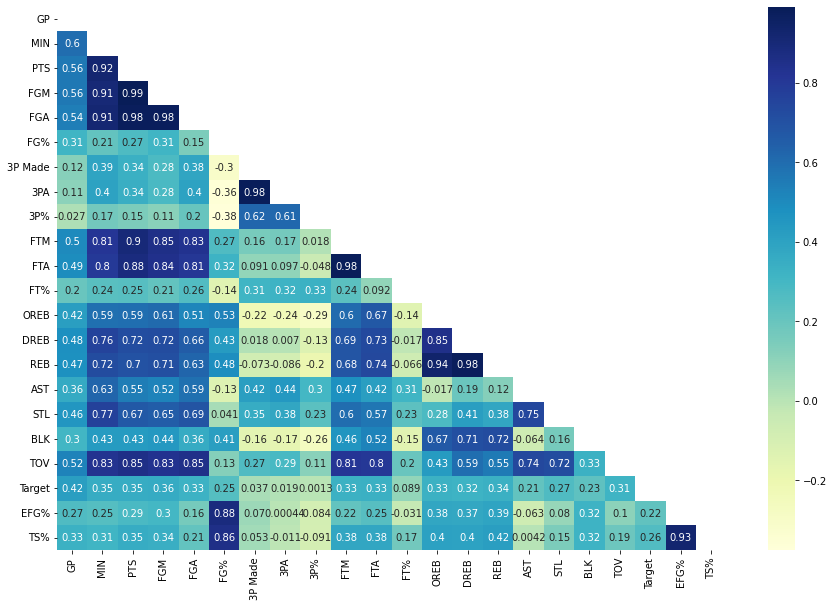

In [266]:
plt.figure(figsize=(15,10))
corr = df_train.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)
sns.heatmap(df_train.corr(), cmap='YlGnBu', annot=True, mask=matrix)

#### First we will try to drop the cols having high correlation among themselves

In [267]:
drop_cols = ['3P Made','3PA','3P%','FT%','REB']
df_train.drop(columns=drop_cols, axis='columns', inplace=True) 
df_test.drop(columns=drop_cols, axis='columns', inplace=True) 

In [268]:
# splitting the data 
X = df_train.drop(columns=['Target'],axis='columns')
y = df_train.Target

In [269]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=0)

In [270]:
print(X_train.shape)
print(X_val.shape)

(880, 16)
(221, 16)


In [271]:
#scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
df_test = scaler.fit_transform(df_test)


In [272]:
print(X_train_scaled)

[[-0.70295848  0.9409833   1.02997183 ...  1.34488418  0.71793175
   1.21985906]
 [ 1.33115663  2.54437453  3.56207243 ...  3.19973756  0.77721855
   1.37720346]
 [ 1.27303905 -0.40139076 -0.0112658  ...  0.20343594  0.36221098
   0.67898318]
 ...
 [ 1.1568039  -0.20252053  0.13072115 ...  0.20343594  0.55567315
   0.77664648]
 [-0.00554759  0.34437261  0.24904361 ...  0.34611697 -0.40312764
   0.09999812]
 [-1.16789908  0.64267795  0.556682   ... -0.08192611 -0.19391585
   0.50653168]]


In [273]:
# Applying the logistic regression model 
lr_model = LogisticRegression(class_weight='balanced')

lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_val_scaled)

print(f"Accuracy Score = {accuracy_score(y_val, lr_pred)}")
conf_mat_lr = confusion_matrix(y_val, lr_pred)
print(conf_mat_lr)
crs_scores = cross_val_score(lr_model, X_val_scaled, y_val, cv=5)
print(crs_scores.mean())

Accuracy Score = 0.6968325791855203
[[81 26]
 [41 73]]
0.6879797979797979


In [274]:
# Applying the XGBoost model
xgb_model = XGBClassifier(n_estimators = 1000, learning_rate=0.01, max_depth=5)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_val_scaled)

print(f"Accuracy Score = {accuracy_score(y_val, xgb_pred)}")
conf_mat_xgb = confusion_matrix(y_val, xgb_pred)
print(conf_mat_xgb)
crs_scores = cross_val_score(xgb_model, X_val_scaled, y_val, cv=5)
print(crs_scores.mean())

Accuracy Score = 0.7330316742081447
[[87 20]
 [39 75]]
0.6468686868686868


In [275]:
# Applying Random forests
rf_model = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=10)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_val_scaled)

print(f"Accuracy Score = {accuracy_score(y_val, rf_pred)}")
conf_mat_rf = confusion_matrix(y_val, rf_pred)
print(conf_mat_rf)
crs_scores = cross_val_score(rf_model, X_val_scaled, y_val, cv=5)
print(crs_scores.mean())

Accuracy Score = 0.7285067873303167
[[85 22]
 [38 76]]
0.674040404040404


In [276]:
# Applying SVM Classifier
svm_model = SVC()
svm_model.fit(X_train_scaled, y_train)
svm_pred = svm_model.predict(X_val_scaled)

print(f"Accuracy Score = {accuracy_score(y_val, svm_pred)}")
conf_mat_svm = confusion_matrix(y_val, svm_pred)
print(conf_mat_svm)
crs_scores = cross_val_score(svm_model, X_val_scaled, y_val, cv=5)
print(crs_scores.mean())

Accuracy Score = 0.7058823529411765
[[88 19]
 [46 68]]
0.6835353535353536


In [277]:
from sklearn.metrics import precision_recall_curve

predicted_probabilities = xgb_model.predict_proba(X_val_scaled)
precision_points,recall_points,threshold_points=precision_recall_curve(y_val,predicted_probabilities[:,1])
precision_points.shape,recall_points.shape,threshold_points.shape

((222,), (222,), (221,))

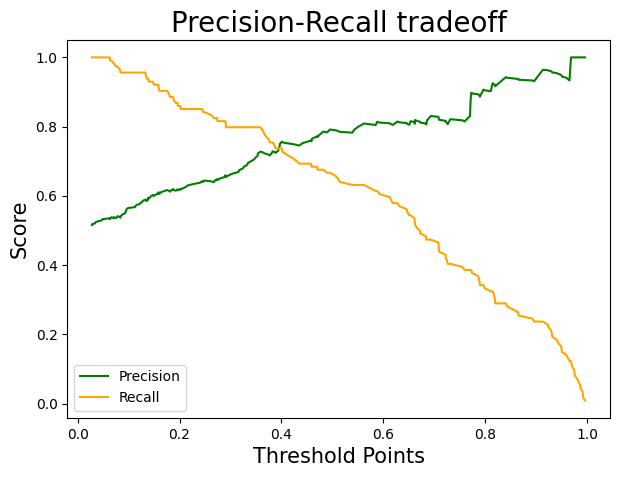

In [278]:

#compare if threshold is less than precision & recall 
#if less -1 minus in plotting
plt.figure(figsize=(7,5),dpi=100)
plt.plot(threshold_points,precision_points[:-1],color='green',label='Precision')
plt.plot(threshold_points,recall_points[:-1],color='orange',label='Recall')
plt.xlabel('Threshold Points',fontsize=15)
plt.ylabel('Score',fontsize=15)
plt.title('Precision-Recall tradeoff',fontsize=20)
plt.legend()

In [279]:
class_rep = classification_report(y_val,xgb_pred)
print(class_rep)

              precision    recall  f1-score   support

           0       0.69      0.81      0.75       107
           1       0.79      0.66      0.72       114

    accuracy                           0.73       221
   macro avg       0.74      0.74      0.73       221
weighted avg       0.74      0.73      0.73       221



In [280]:
class_rep = classification_report(y_val,rf_pred)
print(class_rep)

              precision    recall  f1-score   support

           0       0.69      0.79      0.74       107
           1       0.78      0.67      0.72       114

    accuracy                           0.73       221
   macro avg       0.73      0.73      0.73       221
weighted avg       0.73      0.73      0.73       221



In [284]:
final_preds = xgb_model.predict(df_test)


In [285]:
final_preds.round(0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,

In [286]:
final_preds = pd.DataFrame(final_preds,columns=['prediction'],index=None)
final_preds
print(final_preds)
final_preds.to_csv('Submission.csv')

     prediction
0             0
1             0
2             0
3             0
4             0
..          ...
550           1
551           0
552           1
553           0
554           1

[555 rows x 1 columns]
